In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.1 end  # reward to not lose track of contact
    if range <= 10 return -1 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [25]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [27]:

N = 500
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.5
γ = 0.95
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.95
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);

epochs = 1000
epochsize = 500

total = 0
rando = 0

last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
for i in 1:(epochsize*epochs)
    counter += 1
    
    
    # choose next action
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    u = uu[1]
    rando += uu[2]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
    
    e[:,u] += ξ
    
    total += rew
    
    
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    cur = transpose(θ[:,u])*ξ
    δ = rew + γ * cur - last
    last = cur
    
    θ += α * δ * e
    if uu[2] == 0
        e *= γ * λ
    else
        e = sparse(zeros(length(grid),6))
    end
    
        
    if counter % epochsize == 0
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", total*500/epochsize, " AVG: ", mean(totals), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current3.csv", thetaframe)
    end
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 34.900000000000226 AVG: 24.225714285714496 Epoch: 12 -----------
--------- CURRENT: -30.60000000000017 AVG: 22.70277777777798 Epoch: 13 -----------
--------- CURRENT: 50.00000000000044 AVG: 23.44054054054075 Epoch: 14 -----------
--------- CURRENT: 30.20000000000016 AVG: 23.618421052631785 Epoch: 15 -----------
--------- CURRENT: 50.00000000000044 AVG: 24.29487179487201 Epoch: 16 -----------
--------- CURRENT: 50.00000000000044 AVG: 24.93750000000022 Epoch: 17 -----------
--------- CURRENT: -5.199999999999998 AVG: 24.202439024390458 Epoch: 18 -----------
--------- CURRENT: 50.00000000000044 AVG: 24.816666666666883 Epoch: 19 -----------
--------- CURRENT: -32.60000000000019 AVG: 23.481395348837417 Epoch: 20 -----------
--------- CURRENT: 50.00000000000044 AVG: 24.08409090909112 Epoch: 21 -----------
--------- CURRENT: 50.00000000000044 AVG: 24.660000000000217 Epoch: 22 -----------
--------- CURRENT: -34.40000000000022 AVG: 23.376086956521945 Epoch: 23 -----------
----

--------- CURRENT: 50.00000000000044 AVG: 22.82611940298528 Epoch: 111 -----------
--------- CURRENT: 50.00000000000044 AVG: 23.027407407407615 Epoch: 112 -----------
--------- CURRENT: 40.400000000000304 AVG: 23.155147058823736 Epoch: 113 -----------
--------- CURRENT: -1.600000000000001 AVG: 22.97445255474473 Epoch: 114 -----------
--------- CURRENT: -5.599999999999997 AVG: 22.76739130434803 Epoch: 115 -----------
--------- CURRENT: 50.00000000000044 AVG: 22.96330935251819 Epoch: 116 -----------
--------- CURRENT: -2.0000000000000018 AVG: 22.785000000000206 Epoch: 117 -----------
--------- CURRENT: -39.20000000000029 AVG: 22.34539007092219 Epoch: 118 -----------
--------- CURRENT: -6.199999999999995 AVG: 22.1443661971833 Epoch: 119 -----------
--------- CURRENT: 50.00000000000044 AVG: 22.339160839161043 Epoch: 120 -----------
--------- CURRENT: -14.899999999999789 AVG: 22.08055555555576 Epoch: 121 -----------
--------- CURRENT: 11.500000000000233 AVG: 22.007586206896757 Epoch: 122 --

--------- CURRENT: -34.40000000000022 AVG: 22.76422413793123 Epoch: 209 -----------
--------- CURRENT: 50.00000000000044 AVG: 22.88111587982852 Epoch: 210 -----------
--------- CURRENT: 50.00000000000044 AVG: 22.997008547008743 Epoch: 211 -----------
--------- CURRENT: 41.20000000000037 AVG: 23.07446808510658 Epoch: 212 -----------
--------- CURRENT: 13.199999999999969 AVG: 23.032627118644264 Epoch: 213 -----------
--------- CURRENT: 50.00000000000044 AVG: 23.1464135021099 Epoch: 214 -----------
--------- CURRENT: -19.200000000000006 AVG: 22.968487394958178 Epoch: 215 -----------
--------- CURRENT: -45.20000000000037 AVG: 22.68326359832655 Epoch: 216 -----------
--------- CURRENT: -19.80000000000001 AVG: 22.50625000000019 Epoch: 217 -----------
--------- CURRENT: -42.40000000000033 AVG: 22.2369294605811 Epoch: 218 -----------
--------- CURRENT: 42.20000000000033 AVG: 22.319421487603496 Epoch: 219 -----------
--------- CURRENT: 45.00000000000037 AVG: 22.41275720164628 Epoch: 220 -------

--------- CURRENT: 50.00000000000044 AVG: 22.46242424242444 Epoch: 307 -----------
--------- CURRENT: -0.20000000000000065 AVG: 22.39395770392769 Epoch: 308 -----------
--------- CURRENT: 50.00000000000044 AVG: 22.477108433735136 Epoch: 309 -----------
--------- CURRENT: 

In [24]:
transpose(θ[:,2])*ξ

0.0015269765963268022

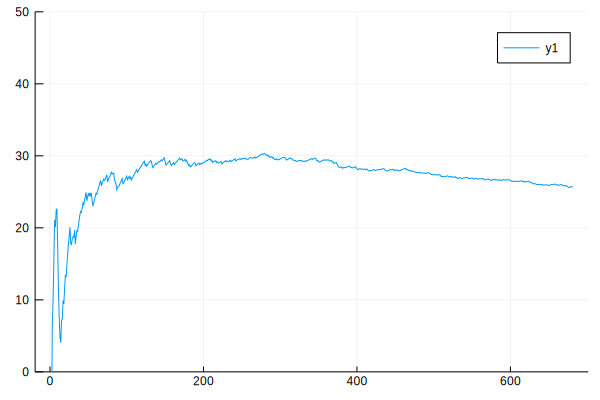

In [19]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (0,50))

2.0131182926706272e35

In [25]:
thetaframe = DataFrame(θ)
CSV.write("0.44_theta_11.28_1", thetaframe)

"0.44_theta_11.28_1"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5